In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, LeakyReLU, concatenate
from keras.models import Model
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import time

In [3]:
# Set seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(123)

In [4]:
# Function to extract input images
def ExtractInput(path):
    X_img = []
    y_img = []
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(os.path.join(path, imageDir))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))
            img_l = img_lab_rs[:, :, 0]
            img_ab = img_lab_rs[:, :, 1:] / 128
            X_img.append(img_l[..., np.newaxis])  # Add channel dimension
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)

    return X_img, y_img

(224, 224, 3)

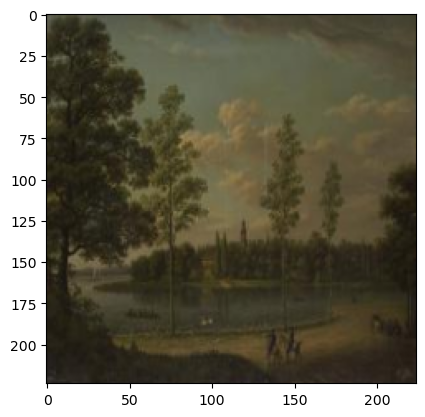

In [6]:
img = cv2.imread("E:/dataset_updated/training_set/painting/1179.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [5]:
# Define constants
HEIGHT = 224
WIDTH = 224
ImagePath = "E:/dataset_updated/training_set/painting"


In [7]:
# Load and preprocess data
X_, y_ = ExtractInput(ImagePath)

In [8]:
# Define model architecture
def InstantiateModel(in_):
    model_ = Conv2D(16, (3, 3), padding='same', strides=1)(in_)
    model_ = LeakyReLU()(model_)
    model_ = Conv2D(32, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2, 2), padding='same')(model_)

    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2, 2), padding='same')(model_)

    model_ = Conv2D(128, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(256, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)

    concat_ = concatenate([model_, in_])

    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(32, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(2, (3, 3), activation='tanh', padding='same', strides=1)(model_)

    return model_

In [9]:
# Define input layer
Input_Sample = Input(shape=(HEIGHT, WIDTH, 1))

In [10]:
# Instantiate the model
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [12]:
# Compile the model
# LEARNING_RATE = 0.001
# Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE), loss='mean_squared_error')
# Model_Colourization.summary()
LEARNING_RATE = 0.001
adam_optimizer = Adam(learning_rate=LEARNING_RATE)
Model_Colourization.compile(optimizer=adam_optimizer, loss='mean_squared_error')
Model_Colourization.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      4,640 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ leaky_re_lu_4[0]

 Total params: 820,386 (3.13 MB)

 Trainable params: 819,042 (3.12 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [13]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


In [14]:
# Define batch size
batch_size = 32

In [15]:
# Generate augmented data
train_generator = datagen.flow(X_, y_, batch_size=batch_size)


In [16]:
# Fit the model
start_time = time.time()
Model_Colourization.fit(train_generator, epochs=30, steps_per_epoch=len(X_) // batch_size, verbose=1)
end_time = time.time()
training_time = end_time - start_time
print("Total training time:", training_time)

Epoch 1/30


C:\Users\kalas\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1925s 30s/step - loss: 0.0993
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0155 
Epoch 3/30


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1487s 23s/step - loss: 0.0072
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 5.2434e-04  
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1779s 28s/step - loss: 0.0015
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0037  
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1535s 24s/step - loss: 0.0015
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0013  
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1784s 28s/step - loss: 8.9550e-04
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0018  
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1601s 25s/step - loss: 0.0011
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 5.3939e-04  
Epoch 13/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1591s 25s/step - loss: 7.6245e-04
Epoch 14/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 7.1135e-04  
Epoch 15/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1552s 25s/step - loss: 6.8186e-04
Epoch 16/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 2.2292e-04  
Epoch 17/30
63/63 ━━━━━━

In [33]:
TestImagePath="E:/dataset_updated/training_set/iconography/"

In [34]:
def ExtractTestInput(ImagePath):
    try:
        img = cv2.imread(ImagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
        img_ = img_.astype(np.float32)
        img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
        img_l = img_lab_rs[:,:,0] # pull out L channel
        img_l_reshaped = img_l.reshape(1,224,224,1)
        return img_l_reshaped 
    except Exception as e:
        print("Error:", e)
        return None


In [36]:
ImagePath=TestImagePath+"16.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


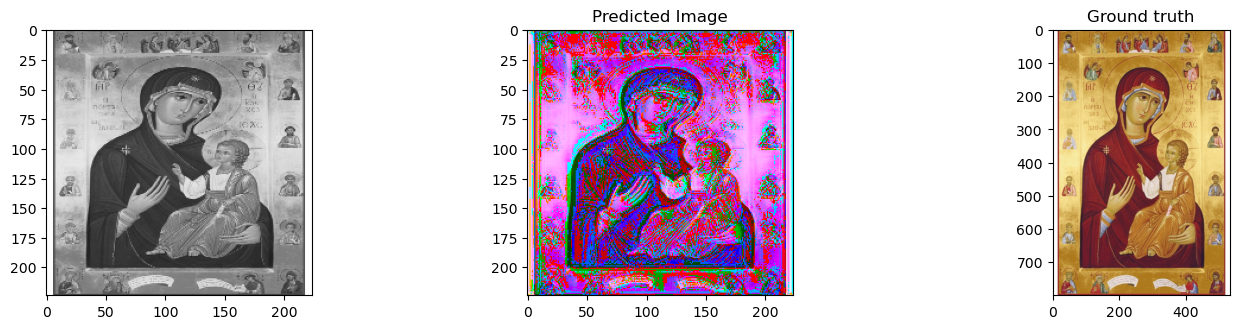

In [40]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"16.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [21]:
ImagePath=TestImagePath+"314.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


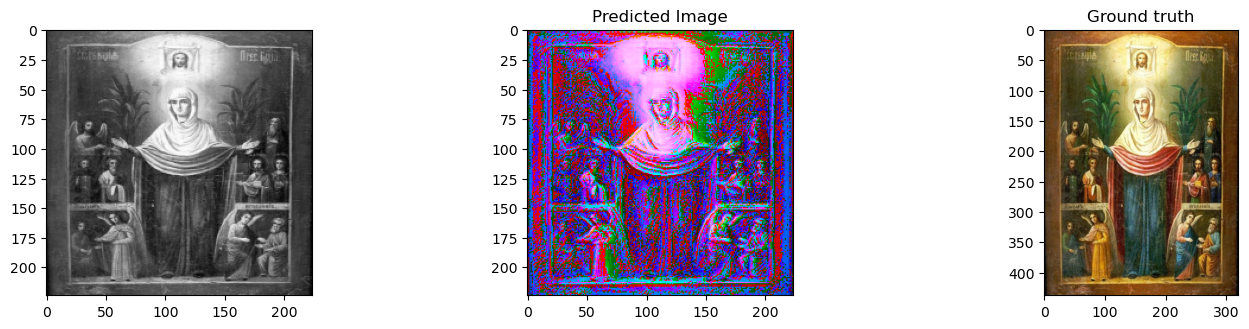

In [22]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"314.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_1
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [23]:
ImagePath=TestImagePath+"698.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_2 = Model_Colourization.predict(image_for_test)
Prediction_2 = Prediction_2*128
Prediction_2=Prediction_2.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


In [24]:
TestImagePath="E:/dataset_updated/training_set/sculpture/240.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_3 = Model_Colourization.predict(image_for_test)
Prediction_3 = Prediction_3*128
Prediction_3=Prediction_3.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


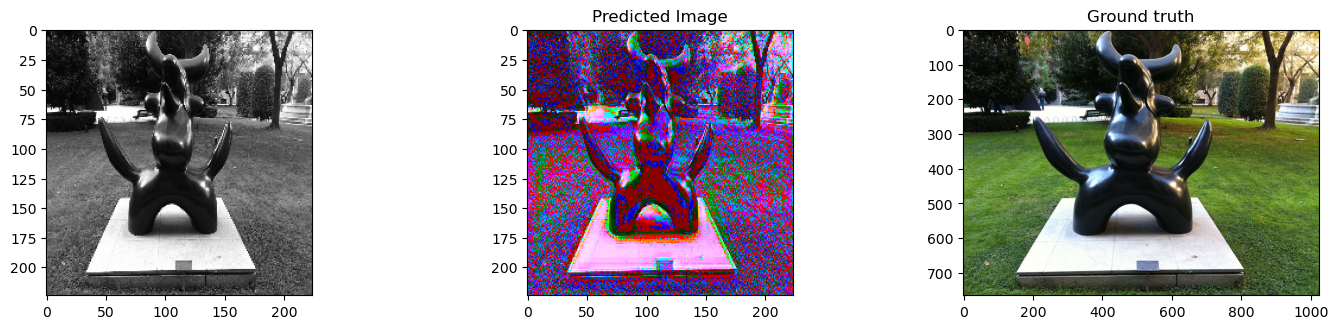

In [25]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_3
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [26]:
TestImagePath="E:/dataset_updated/training_set/painting/1601.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_4 = Model_Colourization.predict(image_for_test)
Prediction_4 = Prediction_4*128
Prediction_4=Prediction_4.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


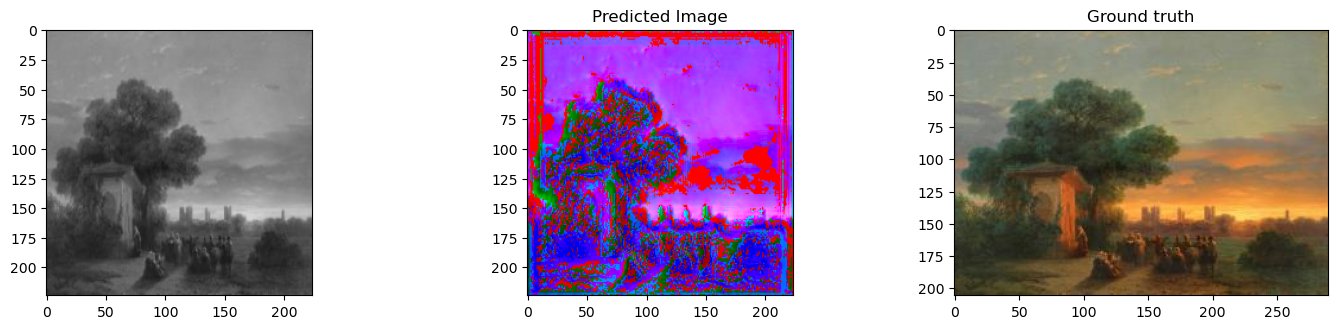

In [27]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_4
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [28]:
TestImagePath="E:/dataset_updated/training_set/painting/1577.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_5 = Model_Colourization.predict(image_for_test)
Prediction_5 = Prediction_5*128
Prediction_5=Prediction_5.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


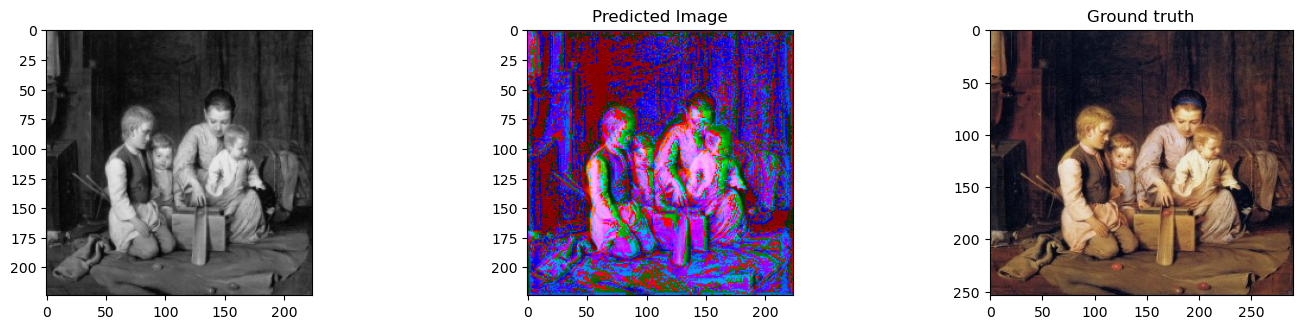

In [29]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_5
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)